# SelfCheck Score Analysis

This notebook loads a saved `scores_*.pkl` file produced by `run_detection_combined.py`, computes ROC/AUC/accuracy/TPR@5%FPR for key metrics, plots ROC curves, and exports a concise CSV summary.

- Dataset: SelfCheck (`potsawee/wiki_bio_gpt3_hallucination`, split `evaluation`)
- Labels: 0 (accurate), 0.5 (minor), 1 (major). We binarize with threshold 0.5.
- Metrics: logit-based (perplexity, window entropy, logit entropy) and attention (mean across layers).



In [6]:
# Config: set the path to the saved scores file
SCORES_PATH = "data/scores_selfcheck_mistral_50samp.pkl"  # change if needed
OUTPUT_CSV = "data/metrics_selfcheck_summary.csv"



In [7]:
import pickle as pkl
import numpy as np
import pandas as pd
from common_utils import get_roc_auc_scores

with open(SCORES_PATH, "rb") as f:
    scores, indiv_scores, labels = pkl.load(f)

# SelfCheck labels: 0 (accurate), 0.5 (minor), 1 (major)
labels = np.array(labels)
y_true = (labels >= 0.5).astype(int)

print("Loaded:", SCORES_PATH)
print("num_samples:", len(y_true), "positives:", int(y_true.sum()))
print("available groups:", list(indiv_scores.keys()))



Loaded: data/scores_selfcheck_mistral_50samp.pkl
num_samples: 1908 positives: 1392
available groups: ['logit', 'attns']


In [8]:
def eval_metric(metric_scores, name):
    auc, acc, tpr5, fpr, tpr = get_roc_auc_scores(np.array(metric_scores), y_true)
    print(f"{name}: auc={auc:.4f} acc={acc:.4f} tpr@5%fpr={tpr5:.4f}")
    return {"metric": name, "auc": auc, "acc": acc, "tpr@5%fpr": tpr5, "fpr": fpr, "tpr": tpr}

summary = []
roc_curves = {}

# Logit-based metrics
if "logit" in indiv_scores:
    for k in ["perplexity", "window_entropy", "logit_entropy"]:
        if k in indiv_scores["logit"]:
            res = eval_metric(indiv_scores["logit"][k], f"logit/{k}")
            summary.append({k2: v for k2, v in res.items() if k2 != "fpr" and k2 != "tpr"})
            roc_curves[f"logit/{k}"] = (res["fpr"], res["tpr"]) 

# Attention: mean across layers
if "attns" in indiv_scores:
    layer_keys = sorted([kk for kk in indiv_scores["attns"] if kk.startswith("Attn")], key=lambda x: int(x[4:]))
    if layer_keys:
        arr = np.stack([np.array(indiv_scores["attns"][kk]) for kk in layer_keys])
        s = arr.mean(0)
        res = eval_metric(s, "attns/mean_layers")
        summary.append({k2: v for k2, v in res.items() if k2 != "fpr" and k2 != "tpr"})
        roc_curves["attns/mean_layers"] = (res["fpr"], res["tpr"]) 

summary_df = pd.DataFrame(summary)
summary_df.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)
summary_df


logit/perplexity: auc=0.4876 acc=0.5307 tpr@5%fpr=0.0352
logit/window_entropy: auc=0.5340 acc=0.5435 tpr@5%fpr=0.0352
logit/logit_entropy: auc=0.6118 acc=0.5972 tpr@5%fpr=0.0575
attns/mean_layers: auc=0.4655 acc=0.5068 tpr@5%fpr=0.0481
Saved: data/metrics_selfcheck_summary.csv


,metric,auc,acc,tpr@5%fpr
0,logit/perplexity,0.487594,0.530699,0.035201
1,logit/window_entropy,0.533976,0.543513,0.035201
2,logit/logit_entropy,0.611767,0.597183,0.057471
3,attns/mean_layers,0.465488,0.506791,0.048132


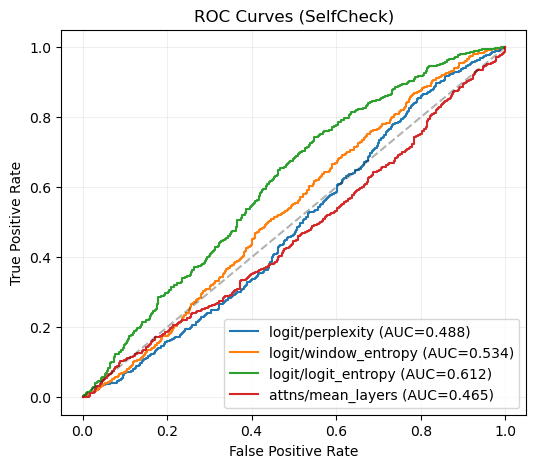

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
for name, (fpr, tpr) in roc_curves.items():
    from sklearn.metrics import auc
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1], 'k--', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (SelfCheck)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()



In [10]:
# Optional: list top-N highest risk samples by a chosen metric
N = 20
if "logit" in indiv_scores and "logit_entropy" in indiv_scores["logit"]:
    s = np.array(indiv_scores["logit"]["logit_entropy"])  # higher = more uncertain
    top_idx = np.argsort(-s)[:N]
    print("Top indices by logit_entropy:", top_idx.tolist())



Top indices by logit_entropy: [1135, 108, 587, 1624, 1260, 760, 1471, 453, 71, 904, 1637, 1083, 1609, 226, 1034, 256, 1488, 927, 1054, 418]


In [11]:
# Balanced evaluation utilities (optional)
from sklearn.metrics import roc_curve

def get_balanced(scores: np.ndarray, labels: np.ndarray):
    labels = np.asarray(labels).astype(int)
    pos_idx = np.where(labels == 1)[0]
    neg_idx = np.where(labels == 0)[0]
    n = min(len(pos_idx), len(neg_idx))
    idx = np.concatenate([pos_idx[:n], neg_idx[:n]])
    return scores[idx], labels[idx]

# Example: balanced summary for logit metrics
balanced_rows = []
if "logit" in indiv_scores:
    for k in ["perplexity", "window_entropy", "logit_entropy"]:
        if k in indiv_scores["logit"]:
            raw = np.array(indiv_scores["logit"][k])
            # Orientation tweaks to make higher = more hallucination, matching FAVA figures
            x = -raw if k == "perplexity" else raw
            xb, yb = get_balanced(x, y_true)
            auc_b, acc_b, tpr5_b, fpr_b, tpr_b = get_roc_auc_scores(xb, yb)[:5]
            balanced_rows.append({"metric": f"balanced/logit/{k}", "auc": auc_b, "acc": acc_b, "tpr@5%fpr": tpr5_b})

balanced_df = pd.DataFrame(balanced_rows)
balanced_path = "data/metrics_selfcheck_balanced_summary.csv"
balanced_df.to_csv(balanced_path, index=False)
print("Saved:", balanced_path)
balanced_df


Saved: data/metrics_selfcheck_balanced_summary.csv


,metric,auc,acc,tpr@5%fpr
0,balanced/logit/perplexity,0.509085,0.533915,0.017442
1,balanced/logit/window_entropy,0.524860,0.530039,0.032946
2,balanced/logit/logit_entropy,0.598894,0.590116,0.050388


Saved: data/metrics_selfcheck_attns_layerwise.csv


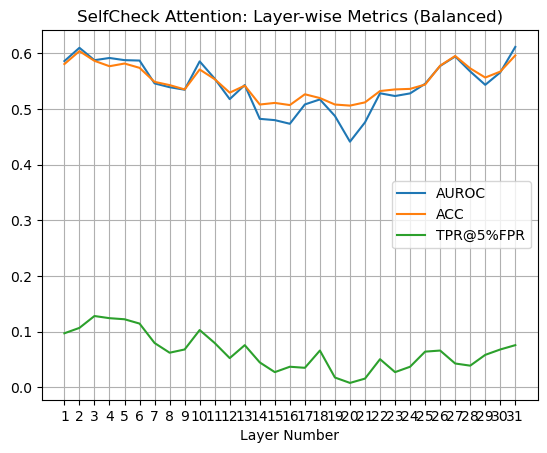

,layer,metric,auc,acc,tpr@5%fpr
0,1,Attn1,0.585760,0.580426,0.096899
1,2,Attn2,0.609633,0.603682,0.106589
2,3,Attn3,0.587375,0.586240,0.127907
3,4,Attn4,0.591359,0.576550,0.124031
4,5,Attn5,0.587461,0.581395,0.122093


In [12]:
# Per-layer Attention ROCs and layerwise plot (mirroring FAVA style)
attn_layer_rows = []
if "attns" in indiv_scores:
    layer_keys = sorted([kk for kk in indiv_scores["attns"] if kk.startswith("Attn")], key=lambda x: int(x[4:]))
    if layer_keys:
        for lk in layer_keys:
            raw = np.array(indiv_scores["attns"][lk])
            x = -raw  # orientation: higher score => more hallucination (as used in FAVA plots)
            xb, yb = get_balanced(x, y_true)
            auc_b, acc_b, tpr5_b, fpr_b, tpr_b = get_roc_auc_scores(xb, yb)[:5]
            layer_num = int(lk[4:])
            attn_layer_rows.append({"layer": layer_num, "metric": lk, "auc": auc_b, "acc": acc_b, "tpr@5%fpr": tpr5_b})

attn_layer_df = pd.DataFrame(attn_layer_rows).sort_values("layer") if len(attn_layer_rows) else pd.DataFrame()
attn_layer_df.to_csv("data/metrics_selfcheck_attns_layerwise.csv", index=False)
print("Saved: data/metrics_selfcheck_attns_layerwise.csv")

if not attn_layer_df.empty:
    plt.clf()
    plt.xticks(list(range(1, attn_layer_df["layer"].max()+1)))
    plt.plot(attn_layer_df["layer"], attn_layer_df["auc"], label="AUROC")
    plt.plot(attn_layer_df["layer"], attn_layer_df["acc"], label="ACC")
    plt.plot(attn_layer_df["layer"], attn_layer_df["tpr@5%fpr"], label="TPR@5%FPR")
    plt.xlabel("Layer Number")
    plt.grid()
    plt.legend()
    plt.title("SelfCheck Attention: Layer-wise Metrics (Balanced)")
    plt.savefig("plots/selfcheck_attns_layerwise.png", dpi=200, bbox_inches="tight")
    plt.show()
attn_layer_df.head()


In [13]:
# Per-layer Hidden ROCs and layerwise plot (mirroring FAVA style)
hid_layer_rows = []
if "hidden" in indiv_scores:
    layer_keys = sorted([kk for kk in indiv_scores["hidden"] if kk.startswith("Hly")], key=lambda x: int(x[3:]))
    if layer_keys:
        for lk in layer_keys:
            raw = np.array(indiv_scores["hidden"][lk])
            x = raw  # hidden SVD score orientation is already higher = more hallucination in repo convention
            xb, yb = get_balanced(x, y_true)
            auc_b, acc_b, tpr5_b, fpr_b, tpr_b = get_roc_auc_scores(xb, yb)[:5]
            layer_num = int(lk[3:])
            hid_layer_rows.append({"layer": layer_num, "metric": lk, "auc": auc_b, "acc": acc_b, "tpr@5%fpr": tpr5_b})

hid_layer_df = pd.DataFrame(hid_layer_rows).sort_values("layer") if len(hid_layer_rows) else pd.DataFrame()
hid_layer_df.to_csv("data/metrics_selfcheck_hidden_layerwise.csv", index=False)
print("Saved: data/metrics_selfcheck_hidden_layerwise.csv")

if not hid_layer_df.empty:
    plt.clf()
    plt.xticks(list(range(1, hid_layer_df["layer"].max()+1)))
    plt.plot(hid_layer_df["layer"], hid_layer_df["auc"], label="AUROC")
    plt.plot(hid_layer_df["layer"], hid_layer_df["acc"], label="ACC")
    plt.plot(hid_layer_df["layer"], hid_layer_df["tpr@5%fpr"], label="TPR@5%FPR")
    plt.xlabel("Layer Number")
    plt.grid()
    plt.legend()
    plt.title("SelfCheck Hidden: Layer-wise Metrics (Balanced)")
    plt.savefig("plots/selfcheck_hidden_layerwise.png", dpi=200, bbox_inches="tight")
    plt.show()
hid_layer_df.head()


Saved: data/metrics_selfcheck_hidden_layerwise.csv


""
